
# Using Information from the rest of a Sequence to Predict the Label for any one Item

In [1]:

%pprint

Pretty printing has been turned OFF


In [21]:

%run ../load_magic/storage.py
s = Storage()
assert s.pickle_exists('HEADER_PATTERN_DICT')
HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')


I have a dictionary of variable-length sequences:

In [9]:

[(file_name[-10:], len(tag_is_header_list)) for file_name,
 tag_is_header_list in HEADER_PATTERN_DICT.items()]

[('37bd1.html', 25), ('0bcce.html', 40), ('90364.html', 28), ('8f9c7.html', 24), ('d12d4.html', 73), ('46837.html', 37), ('adb92.html', 53), ('0a1e7.html', 69), ('da077.html', 43), ('9366a.html', 21), ('6ae4d.html', 37), ('f62ee.html', 19), ('73aee.html', 33), ('e090a.html', 35), ('8b093.html', 44)]


These contain a label for each item as to whether or not they are a subject heading:

In [10]:

HEADER_PATTERN_DICT[sorted([(file_name, len(tag_is_header_list)) for file_name,
                            tag_is_header_list in HEADER_PATTERN_DICT.items()],
                           key=lambda x: x[1])[0][0]]

[('', True), ('<div', False), ('<div', False), ('', True), ('', False), ('<li', False), ('<li', False), ('<li', False), ('', False), ('', False), ('<li', False), ('<li', False), ('<li', False), ('', True), ('', True), ('<li', False), ('<li', False), ('<li', False), ('<div', False)]


Every item in the sequence is an instance for which the label should be predicted. So, what is the best way to use some variable-length sequence vectorization to train a model to predict the label?


----

In [46]:

from itertools import chain
import nltk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
import pycrfsuite
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

[f'sklearn_crfsuite.{fn}' for fn in dir(sklearn_crfsuite) if not fn.startswith('_')]

['sklearn_crfsuite.CRF', 'sklearn_crfsuite.compat', 'sklearn_crfsuite.estimator', 'sklearn_crfsuite.metrics', 'sklearn_crfsuite.scorers', 'sklearn_crfsuite.trainer', 'sklearn_crfsuite.utils']

In [34]:

from pycrfsuite import ItemSequence

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
sequence_obj_dict = {file_name: ItemSequence(feature_dict_list) for file_name, feature_dict_list in HEADER_PATTERN_DICT.items()}

In [32]:

import random

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
sequence_obj = ItemSequence(feature_dict_list)
sequence_obj.items()

[{'initial_tag:h2': 1.0, 'is_header': 1.0}, {'initial_tag:p': 1.0, 'is_header': 0.0}, {'initial_tag:p': 1.0, 'is_header': 0.0}, {'initial_tag:p': 1.0, 'is_header': 0.0}, {'initial_tag:b': 1.0, 'is_header': 1.0}, {'initial_tag:plaintext': 1.0, 'is_header': 0.0}, {'initial_tag:plaintext': 1.0, 'is_header': 0.0}, {'initial_tag:plaintext': 1.0, 'is_header': 0.0}, {'initial_tag:li': 1.0, 'is_header': 0.0}, {'initial_tag:p': 1.0, 'is_header': 0.0}, {'initial_tag:b': 1.0, 'is_header': 1.0}, {'initial_tag:p': 1.0, 'is_header': 0.0}, {'initial_tag:b': 1.0, 'is_header': 1.0}, {'initial_tag:plaintext': 1.0, 'is_header': 1.0}, {'initial_tag:b': 1.0, 'is_header': 0.0}, {'initial_tag:plaintext': 1.0, 'is_header': 0.0}, {'initial_tag:b': 1.0, 'is_header': 0.0}, {'initial_tag:plaintext': 1.0, 'is_header': 0.0}, {'initial_tag:b': 1.0, 'is_header': 0.0}, {'initial_tag:plaintext': 1.0, 'is_header': 0.0}, {'initial_tag:b': 1.0, 'is_header': 0.0}, {'initial_tag:plaintext': 1.0, 'is_header': 0.0}, {'initial

In [51]:

[(feature_dict['initial_tag'], 'H' if feature_dict['is_header'] else 'O') for feature_dict in feature_dict_list]

[('h2', 'H'), ('p', 'O'), ('p', 'O'), ('p', 'O'), ('b', 'H'), ('plaintext', 'O'), ('plaintext', 'O'), ('plaintext', 'O'), ('li', 'O'), ('p', 'O'), ('b', 'H'), ('p', 'O'), ('b', 'H'), ('plaintext', 'H'), ('b', 'O'), ('plaintext', 'O'), ('b', 'O'), ('plaintext', 'O'), ('b', 'O'), ('plaintext', 'O'), ('b', 'O'), ('plaintext', 'O'), ('b', 'O'), ('b', 'H'), ('li', 'O'), ('li', 'O'), ('li', 'O'), ('li', 'O'), ('plaintext', 'O'), ('b', 'H'), ('p', 'O'), ('plaintext', 'O'), ('b', 'O'), ('plaintext', 'O'), ('p', 'O'), ('p', 'O'), ('p', 'O'), ('p', 'O'), ('b', 'H'), ('p', 'O'), ('plaintext', 'O'), ('b', 'O'), ('plaintext', 'O'), ('p', 'O'), ('p', 'O'), ('p', 'O'), ('p', 'O'), ('p', 'O'), ('b', 'H'), ('plaintext', 'O'), ('b', 'O'), ('b', 'O'), ('plaintext', 'O')]

In [54]:

tag_set = set()
for file_name, feature_dict_list in HEADER_PATTERN_DICT.items():
    for feature_dict in feature_dict_list:
        tag_set.add(feature_dict['initial_tag'])
print(f"<({'|'.join(tag_set)})>")

<(i|plaintext|h2|p|b|li|div)


In [2]:

inital_tag_sets_list = [document_body_elements_set, block_elements_set, basic_text_set, section_headings_set, lists_set,
                        other_block_elements_set, inline_elements_set, phrase_elements_set, presentation_set]
null_element = 'plaintext'
document_body_elements_set in inital_tag_sets_list

True

In [1]:

%run ../py/tag_sets.py
print()
for set_str in [fn for fn in dir() if type(eval(fn)) == set]:
    print(f"""        'tag.{set_str}': tag in {set_str},""")


        'tag.anchor_set': tag in anchor_set,
        'tag.basic_text_set': tag in basic_text_set,
        'tag.block_elements_set': tag in block_elements_set,
        'tag.computer_phrase_elements_set': tag in computer_phrase_elements_set,
        'tag.document_body_elements_set': tag in document_body_elements_set,
        'tag.document_head_elements_set': tag in document_head_elements_set,
        'tag.document_structure_elements_set': tag in document_structure_elements_set,
        'tag.forms_set': tag in forms_set,
        'tag.frames_set': tag in frames_set,
        'tag.general_set': tag in general_set,
        'tag.historic_elements_set': tag in historic_elements_set,
        'tag.images_and_objects_set': tag in images_and_objects_set,
        'tag.inline_elements_set': tag in inline_elements_set,
        'tag.lists_set': tag in lists_set,
        'tag.non_standard_elements_set': tag in non_standard_elements_set,
        'tag.other_block_elements_set': tag in other_block_element

In [4]:

inital_tag_sets_list = [document_body_elements_set, block_elements_set, basic_text_set, section_headings_set, lists_set,
                        other_block_elements_set, inline_elements_set, phrase_elements_set, presentation_set]
null_element = 'plaintext'
print()
for set_str in [fn for fn in dir() if eval(fn) in inital_tag_sets_list]:
    print(f"""            '+1:tag.{set_str}': tag1 in {set_str},""")


            '+1:tag.basic_text_set': tag1 in basic_text_set,
            '+1:tag.block_elements_set': tag1 in block_elements_set,
            '+1:tag.document_body_elements_set': tag1 in document_body_elements_set,
            '+1:tag.inline_elements_set': tag1 in inline_elements_set,
            '+1:tag.lists_set': tag1 in lists_set,
            '+1:tag.other_block_elements_set': tag1 in other_block_elements_set,
            '+1:tag.phrase_elements_set': tag1 in phrase_elements_set,
            '+1:tag.presentation_set': tag1 in presentation_set,
            '+1:tag.section_headings_set': tag1 in section_headings_set,


In [14]:

null_element = 'plaintext'
def word2features(sent, i):
    tag = sent[i][0]
    
    features = {
        'bias': 1.0,
        'tag.document_body_elements_set': tag in document_body_elements_set,
        'tag.block_elements_set': tag in block_elements_set,
        'tag.basic_text_set': tag in basic_text_set,
        'tag.section_headings_set': tag in section_headings_set,
        'tag.lists_set': tag in lists_set,
        'tag.other_block_elements_set': tag in other_block_elements_set,
        'tag.inline_elements_set': tag in inline_elements_set,
        'tag.phrase_elements_set': tag in phrase_elements_set,
        'tag.presentation_set': tag in presentation_set,
        'tag.null_element': tag == null_element,
    }
    if i > 0:
        tag1 = sent[i-1][0]
        features.update({
            '-1:tag.document_body_elements_set': tag1 in document_body_elements_set,
            '-1:tag.block_elements_set': tag1 in block_elements_set,
            '-1:tag.basic_text_set': tag1 in basic_text_set,
            '-1:tag.section_headings_set': tag1 in section_headings_set,
            '-1:tag.lists_set': tag1 in lists_set,
            '-1:tag.other_block_elements_set': tag1 in other_block_elements_set,
            '-1:tag.inline_elements_set': tag1 in inline_elements_set,
            '-1:tag.phrase_elements_set': tag1 in phrase_elements_set,
            '-1:tag.presentation_set': tag1 in presentation_set,
            '-1:tag.null_element': tag1 == null_element,
            '-1:previous==tag': tag1 == tag,
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        tag1 = sent[i+1][0]
        features.update({
            '+1:tag.basic_text_set': tag1 in basic_text_set,
            '+1:tag.block_elements_set': tag1 in block_elements_set,
            '+1:tag.document_body_elements_set': tag1 in document_body_elements_set,
            '+1:tag.inline_elements_set': tag1 in inline_elements_set,
            '+1:tag.lists_set': tag1 in lists_set,
            '+1:tag.other_block_elements_set': tag1 in other_block_elements_set,
            '+1:tag.phrase_elements_set': tag1 in phrase_elements_set,
            '+1:tag.presentation_set': tag1 in presentation_set,
            '+1:tag.section_headings_set': tag1 in section_headings_set,
            '+1:tag.null_element': tag1 == null_element,
            '+1:tag==previous': tag1 == tag,
        })
    else:
        features['EOS'] = True
        
    if i < len(sent)-2:
        tag1 = sent[i+1][0]
        tag2 = sent[i+2][0]
        features.update({
            '+2:tag.basic_text_set': tag2 in basic_text_set,
            '+2:tag.block_elements_set': tag2 in block_elements_set,
            '+2:tag.document_body_elements_set': tag2 in document_body_elements_set,
            '+2:tag.inline_elements_set': tag2 in inline_elements_set,
            '+2:tag.lists_set': tag2 in lists_set,
            '+2:tag.other_block_elements_set': tag2 in other_block_elements_set,
            '+2:tag.phrase_elements_set': tag2 in phrase_elements_set,
            '+2:tag.presentation_set': tag2 in presentation_set,
            '+2:tag.section_headings_set': tag2 in section_headings_set,
            '+2:tag.null_element': tag2 == null_element,
            '+2:tag==previous': tag2 == tag1,
        })
                
    return features.copy()

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [15]:

import random
%run ../load_magic/storage.py
s = Storage()

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
sent = [(feature_dict['initial_tag'], 'H' if feature_dict['is_header'] else 'O') for feature_dict in feature_dict_list]
print()
features_dict = random.choice(sent2features(sent))
features_dict

{'bias': 1.0,
 'tag.document_body_elements_set': True,
 'tag.block_elements_set': True,
 'tag.basic_text_set': False,
 'tag.section_headings_set': False,
 'tag.lists_set': True,
 'tag.other_block_elements_set': False,
 'tag.inline_elements_set': False,
 'tag.phrase_elements_set': False,
 'tag.presentation_set': False,
 'tag.null_element': False,
 '-1:tag.document_body_elements_set': True,
 '-1:tag.block_elements_set': True,
 '-1:tag.basic_text_set': False,
 '-1:tag.section_headings_set': False,
 '-1:tag.lists_set': True,
 '-1:tag.other_block_elements_set': False,
 '-1:tag.inline_elements_set': False,
 '-1:tag.phrase_elements_set': False,
 '-1:tag.presentation_set': False,
 '-1:tag.null_element': False,
 '-1:previous==tag': True,
 '+1:tag.basic_text_set': False,
 '+1:tag.block_elements_set': True,
 '+1:tag.document_body_elements_set': True,
 '+1:tag.inline_elements_set': False,
 '+1:tag.lists_set': True,
 '+1:tag.other_block_elements_set': False,
 '+1:tag.phrase_elements_set': False,
 '

In [16]:

from sklearn.model_selection import train_test_split

all_sents = []
for file_name, feature_dict_list in HEADER_PATTERN_DICT.items():
    feature_dict_list = [(feature_dict['initial_tag'], 'H' if feature_dict['is_header'] else 'O') for feature_dict in feature_dict_list]
    all_sents.append(feature_dict_list)
X = [sent2features(s) for s in all_sents]
y = [sent2labels(s) for s in all_sents]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [59]:

%%time
import sklearn_crfsuite

CRF = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
CRF.fit(X_train, y_train)

Wall time: 357 ms


C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [60]:

labels = list(CRF.classes_)
#labels.remove('O')
labels

['H', 'O']

In [62]:

from sklearn_crfsuite import metrics

y_pred = CRF.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.9089928445579087

In [63]:

print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

              precision    recall  f1-score   support

           H      0.789     0.652     0.714        23
           O      0.932     0.965     0.948       114

    accuracy                          0.912       137
   macro avg      0.861     0.809     0.831       137
weighted avg      0.908     0.912     0.909       137



C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['H', 'O'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "



----
## Make a Prediction Visualization

In [67]:

import re

LT_REGEX = re.compile(r'\s+<')
GT_REGEX = re.compile(r'>\s+')
def clean_html_str(html_obj):
    html_str = str(html_obj)
    html_str = html_str.strip()
    html_str = LT_REGEX.sub('<', html_str)
    html_str = GT_REGEX.sub('>', html_str)
    
    return html_str

In [56]:

from bs4.element import NavigableString

def get_navigable_children(tag, result_list=[]):
    if type(tag) is not NavigableString:
        for child_tag in tag.children:
            result_list = get_navigable_children(child_tag, result_list)
    else:
        base_str = clean_html_str(tag)
        if base_str:
            tag_str = clean_html_str(tag.parent)
            if tag_str.count('<') > 2:
                tag_str = base_str
            result_list.append(tag_str)
    
    return result_list

In [58]:

from bs4 import BeautifulSoup

SAVES_HTML_FOLDER = os.path.join(s.saves_folder, 'html')
files_list = os.listdir(SAVES_HTML_FOLDER)
def get_child_strs_from_file(file_name):
    child_strs_list = []
    file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        html_str = f.read()
        job_soup = BeautifulSoup(html_str, 'lxml')
        body_soup = job_soup.find_all(name='body')[0]
        child_strs_list = get_navigable_children(body_soup, [])
    
    return child_strs_list

In [91]:

import matplotlib.pyplot as plt
import numpy as np

BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
def plot_child_str_predictions(file_name):
    child_strs_list = get_child_strs_from_file(file_name)
    if file_name in HEADER_PATTERN_DICT:
        feature_dict_list = HEADER_PATTERN_DICT[file_name]
        feature_tuple_list = [(feature_dict['initial_tag'],
                               'H' if feature_dict['is_header'] else 'O') for feature_dict in feature_dict_list]
        prediction_dict_list = CRF.predict_marginals_single(sent2features(feature_tuple_list))
    else:
        prediction_dict_list = [{'H': np.nan} for i in range(len(child_strs_list))]
    rows_list = []
    for child_str, marginals_dict in zip(child_strs_list, prediction_dict_list):
        row_dict = {'probability': marginals_dict['H']}
        if child_str in BASIC_TAGS_DICT:
            row_dict['actual'] = BASIC_TAGS_DICT[child_str] * 1.0
        else:
            row_dict['actual'] = np.nan
        rows_list.append(row_dict)
    ax = plt.figure(figsize=(18, 2.5)).add_subplot(1, 1, 1)
    AxesSubplot_obj = pd.DataFrame(rows_list).plot.line(ax=ax)
    ax.axis('off')
    for x, child_str in enumerate(child_strs_list):
        y = rows_list[x]['probability']
        if str(y) == 'nan':
            y = rows_list[x]['actual']
        if str(y) != 'nan':
            ax.annotate(f'{child_str[:20]}...', (x, y), ha='left', rotation=90)

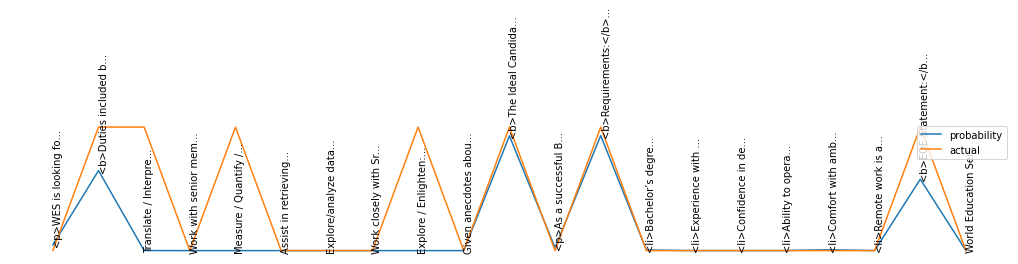

In [93]:

file_name = random.choice(files_list)
while file_name not in HEADER_PATTERN_DICT:
    file_name = random.choice(files_list)
plot_child_str_predictions(file_name)

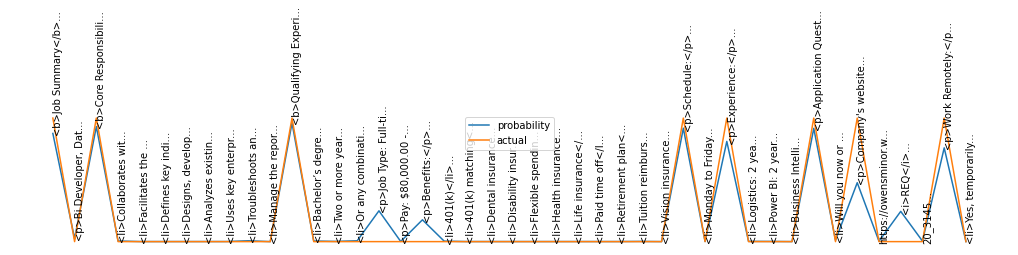

In [94]:

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
plot_child_str_predictions(file_name)


----

In [47]:

[f'sklearn_crfsuite.CRF.{fn}' for fn in dir(sklearn_crfsuite.CRF) if not fn.startswith('_')]

['sklearn_crfsuite.CRF.attributes_', 'sklearn_crfsuite.CRF.classes_', 'sklearn_crfsuite.CRF.fit', 'sklearn_crfsuite.CRF.get_params', 'sklearn_crfsuite.CRF.num_attributes_', 'sklearn_crfsuite.CRF.predict', 'sklearn_crfsuite.CRF.predict_marginals', 'sklearn_crfsuite.CRF.predict_marginals_single', 'sklearn_crfsuite.CRF.predict_single', 'sklearn_crfsuite.CRF.score', 'sklearn_crfsuite.CRF.set_params', 'sklearn_crfsuite.CRF.size_', 'sklearn_crfsuite.CRF.state_features_', 'sklearn_crfsuite.CRF.tagger_', 'sklearn_crfsuite.CRF.transition_features_']

In [ ]:

pycrfsuite.tempfile?

In [42]:

[f'pycrfsuite.contextlib.{fn}' for fn in dir(pycrfsuite.contextlib) if not fn.startswith('_')]

['pycrfsuite.contextlib.AbstractAsyncContextManager', 'pycrfsuite.contextlib.AbstractContextManager', 'pycrfsuite.contextlib.AsyncExitStack', 'pycrfsuite.contextlib.ContextDecorator', 'pycrfsuite.contextlib.ExitStack', 'pycrfsuite.contextlib.GenericAlias', 'pycrfsuite.contextlib.MethodType', 'pycrfsuite.contextlib.abc', 'pycrfsuite.contextlib.asynccontextmanager', 'pycrfsuite.contextlib.closing', 'pycrfsuite.contextlib.contextmanager', 'pycrfsuite.contextlib.deque', 'pycrfsuite.contextlib.nullcontext', 'pycrfsuite.contextlib.redirect_stderr', 'pycrfsuite.contextlib.redirect_stdout', 'pycrfsuite.contextlib.suppress', 'pycrfsuite.contextlib.sys', 'pycrfsuite.contextlib.wraps']

In [37]:

[f'pycrfsuite.Trainer.{fn}' for fn in dir(pycrfsuite.Trainer) if not fn.startswith('_')]

['pycrfsuite.Trainer.append', 'pycrfsuite.Trainer.clear', 'pycrfsuite.Trainer.get', 'pycrfsuite.Trainer.get_params', 'pycrfsuite.Trainer.help', 'pycrfsuite.Trainer.logparser', 'pycrfsuite.Trainer.message', 'pycrfsuite.Trainer.on_end', 'pycrfsuite.Trainer.on_featgen_end', 'pycrfsuite.Trainer.on_featgen_progress', 'pycrfsuite.Trainer.on_iteration', 'pycrfsuite.Trainer.on_optimization_end', 'pycrfsuite.Trainer.on_prepare_error', 'pycrfsuite.Trainer.on_prepared', 'pycrfsuite.Trainer.on_start', 'pycrfsuite.Trainer.params', 'pycrfsuite.Trainer.select', 'pycrfsuite.Trainer.set', 'pycrfsuite.Trainer.set_params', 'pycrfsuite.Trainer.train', 'pycrfsuite.Trainer.verbose']

In [35]:

[f'pycrfsuite.Tagger.{fn}' for fn in dir(pycrfsuite.Tagger) if not fn.startswith('_')]

['pycrfsuite.Tagger.close', 'pycrfsuite.Tagger.dump', 'pycrfsuite.Tagger.info', 'pycrfsuite.Tagger.labels', 'pycrfsuite.Tagger.marginal', 'pycrfsuite.Tagger.open', 'pycrfsuite.Tagger.open_inmemory', 'pycrfsuite.Tagger.probability', 'pycrfsuite.Tagger.set', 'pycrfsuite.Tagger.tag']


----

In [41]:

true_idx_dict = {}
double_header_dict = {}
for file_name, tag_is_header_list in HEADER_PATTERN_DICT.items():
    true_idx_list = []
    double_header_idx_list = []
    for i, tag_tuple in enumerate(tag_is_header_list):
        if tag_tuple[1]:
            true_idx_list.append(i)
    for idx in true_idx_list:
        next_idx = idx + 1
        if next_idx < len(tag_is_header_list):
            item_tag = tag_is_header_list[next_idx][0]
            item_idx = next_idx + 1
            while (item_idx < len(tag_is_header_list)) and (tag_is_header_list[item_idx][0] == item_tag):
                item_tag = tag_is_header_list[item_idx][0]
                item_idx = item_idx + 1
            if (item_idx < len(tag_is_header_list)) and tag_is_header_list[item_idx][1]:
                idx_tuple = (idx, item_idx)
                double_header_idx_list.append(idx_tuple)
    if len(double_header_idx_list):
        double_header_dict[file_name] = double_header_idx_list
    if len(true_idx_list):
        true_idx_dict[file_name] = true_idx_list

In [40]:

file_name = sorted([(f, l) for f, l in double_header_dict.items()], key=lambda x: len(x[1]))[-1][0]
child_strs_list = get_child_strs_from_file(file_name)

In [45]:

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText

# Re-transform the bag-of-words and tf-idf from the new manual scores
rows_list = [{'navigable_parent': navigable_parent, 'is_header': is_header} for navigable_parent, is_header in BASIC_TAGS_DICT.items()]
child_str_df = pd.DataFrame(rows_list)

assert child_str_df.shape[0]
sents_list = child_str_df.navigable_parent.tolist()
CLF_NAME = 'LdaModel'
#CLF_NAME = 'LogisticRegression'

In [46]:

if(CLF_NAME == 'LdaModel'):
    
    # Build model with tokenized words
    tokenized_sents_list = [regex_tokenizer(sent_str) for sent_str in sents_list]
    
    # Create a corpus from a list of texts
    HEADERS_DICTIONARY = Dictionary(tokenized_sents_list)
    headers_corpus = [HEADERS_DICTIONARY.doc2bow(tag_str) for tag_str in tokenized_sents_list]
    
    # Train the model on the corpus
    LDA = LdaModel(corpus=headers_corpus, num_topics=2)
    
else:
    
    # Bag-of-words
    cv = CountVectorizer(**{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'lowercase': False, 'max_df': 1.0,
                            'max_features': None, 'min_df': 0.0, 'ngram_range': (1, 5), 'stop_words': None, 'strip_accents': 'ascii',
                            'tokenizer': regex_tokenizer})
    
    # The shape of the count vector here should be n sentences * m unique words
    bow_matrix = cv.fit_transform(sents_list)
    
    # Store the resulting vocabulary; the numbers are not counts, they are the position in the sparse vector
    s.store_objects(cs_cv_vocab=cv.vocabulary_)
    
    # Tf-idf must get from Bag-of-words first
    tt = TfidfTransformer(**{'norm': 'l1', 'smooth_idf': True, 'sublinear_tf': False, 'use_idf': True})
    tfidf_matrix = tt.fit_transform(bow_matrix)
    s.store_objects(CS_TT=tt)
    
    # Re-train the classifier
    X = tfidf_matrix.toarray()
    y = child_str_df.is_header.to_numpy()
    FIT_ESTIMATORS_DICT = s.load_object('FIT_ESTIMATORS_DICT')
    child_str_clf = FIT_ESTIMATORS_DICT[CLF_NAME]
    child_str_clf.fit(X, y)
    FIT_ESTIMATORS_DICT[CLF_NAME] = child_str_clf
    s.store_objects(child_str_clf=child_str_clf, FIT_ESTIMATORS_DICT=FIT_ESTIMATORS_DICT)
    
    # Re-calibrate the inference engine
    cs_cv_vocab = s.load_object('cs_cv_vocab')
    CS_CV = CountVectorizer(vocabulary=cs_cv_vocab)
    CS_CV._validate_vocabulary()
    CS_TT = s.load_object('CS_TT')

In [67]:

def predict_percent_fit(navigable_parents_list):
    y_predict_proba_list = []
    for navigable_parent in navigable_parents_list:
        if(CLF_NAME == 'LdaModel'):
            X_test = HEADERS_DICTIONARY.doc2bow(regex_tokenizer(navigable_parent))
            result_list = LDA[X_test]
            if len(result_list) == 1:
                result_tuple = result_list[0]
            elif len(result_list) == 2:
                result_tuple = result_list[1]
                
            # Assume it's the probability of the larger topic
            y_predict_proba = 1.0 - result_tuple[1]	   
        
        else:
            X_test = CS_TT.transform(CS_CV.transform(navigable_parents_list)).toarray()
            y_predict_proba = child_str_clf.predict_proba(X_test)
        y_predict_proba_list.append(y_predict_proba)
    
    return y_predict_proba_list

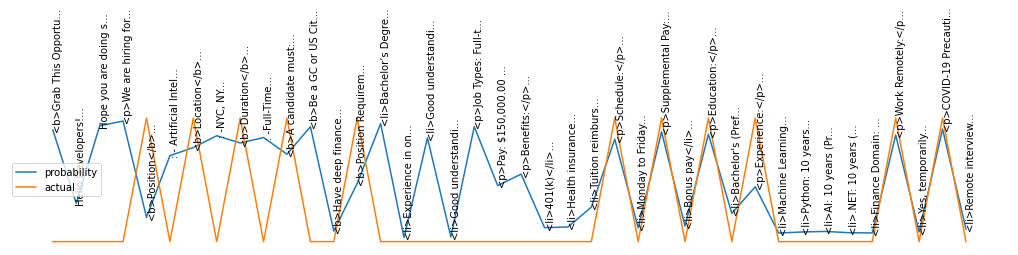

In [68]:

import matplotlib.pyplot as plt

rows_list = []
for child_str in child_strs_list:
    y_predict_proba = predict_percent_fit([child_str])[0]
    if(CLF_NAME == 'LdaModel'):
        X = 1.0 - y_predict_proba
    else:
        X = y_predict_proba[0][1]
    row_dict = {'probability': X}
    if child_str in BASIC_TAGS_DICT:
        row_dict['actual'] = BASIC_TAGS_DICT[child_str] * 1.0
    else:
        row_dict['actual'] = np.nan
    rows_list.append(row_dict)
ax = plt.figure(figsize=(18, 2.5)).add_subplot(1, 1, 1)
df = pd.DataFrame(rows_list)
AxesSubplot_obj = df.plot.line(ax=ax)
ax.axis('off')
for i, child_str in enumerate(child_strs_list):
    ax.annotate(f'{child_str[:20]}...', (i, rows_list[i]['probability']), ha='left', rotation=90)


----

In [ ]:

from IPython.display import clear_output
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from urllib.parse import urlparse, parse_qs
import numpy as np
import os
import random
import re
import requests
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText


In [ ]:

SCANNER_REGEX = re.compile(r'</?\w+|\w+[#\+]*|:|\.|\?')
def regex_tokenizer(corpus):
    
    return [match.group() for match in re.finditer(SCANNER_REGEX, corpus)]

In [ ]:

from IPython.display import HTML, display
import pylab
import matplotlib.pyplot as plt

cmap = pylab.cm.get_cmap('coolwarm')
def html2text(html_str, prob_float):
    html_str = html_str.replace('<', '&lt;').replace('>', '&gt;')
    hex_str = '%02x%02x%02x' % cmap(X=prob_float, bytes=True)[:-1]
    html_str = f'<span style="color:#{hex_str}">{html_str}</span>'
    
    return html_str


----
# Create the Header Pattern Dictionary

In [30]:

from bs4 import BeautifulSoup
import re
%run ../load_magic/storage.py
s = Storage()

SAVES_HTML_FOLDER = os.path.join(s.saves_folder, 'html')
files_list = os.listdir(SAVES_HTML_FOLDER)

SCANNER_REGEX = re.compile(r'</?\w+|\w+[#\+]*|:|\.|\?')
def regex_tokenizer(corpus):
    
    return [match.group() for match in re.finditer(SCANNER_REGEX, corpus)]

assert s.pickle_exists('CHILD_STRS_LIST_DICT')
CHILD_STRS_LIST_DICT = s.load_object('CHILD_STRS_LIST_DICT')
assert s.pickle_exists('BASIC_TAGS_DICT')
BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
HEADER_PATTERN_DICT = {}
for file_name in files_list:
    if file_name in CHILD_STRS_LIST_DICT:
        child_strs_list = CHILD_STRS_LIST_DICT[file_name]
    else:
        file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            html_str = f.read()
            job_soup = BeautifulSoup(html_str, 'lxml')
            body_soup = job_soup.find_all(name='body')[0]
            child_strs_list = get_navigable_children(body_soup, [])
    navigable_parent = child_strs_list[0]
    if navigable_parent not in BASIC_TAGS_DICT:
        continue
    child_tags_list = []
    is_header_list = []
    for navigable_parent in child_strs_list:
        if navigable_parent not in BASIC_TAGS_DICT:
            break
        tokenized_sent = regex_tokenizer(navigable_parent)
        first_token = tokenized_sent[0]
        if first_token[0] == '<':
            child_tags_list.append(first_token[1:])
        else:
            child_tags_list.append('plaintext')
        is_header = BASIC_TAGS_DICT[navigable_parent]
        is_header_list.append(is_header)
    if len(child_tags_list) == len(child_strs_list):
        if file_name not in CHILD_STRS_LIST_DICT:
            CHILD_STRS_LIST_DICT[file_name] = child_strs_list
            s.store_objects(CHILD_STRS_LIST_DICT=CHILD_STRS_LIST_DICT)
        if file_name not in HEADER_PATTERN_DICT:
            item_sequence = [{'initial_tag': tag, 'is_header': is_header} for tag, is_header in zip(child_tags_list, is_header_list)]
            HEADER_PATTERN_DICT[file_name] = item_sequence
            s.store_objects(HEADER_PATTERN_DICT=HEADER_PATTERN_DICT)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle


In [4]:

import sys

command_str = f'{sys.executable} -m pip install --upgrade sklearn-crfsuite'
print(command_str)
!{command_str}

C:\Users\dev\Anaconda3\envs\jh\python.exe -m pip install --upgrade sklearn-crfsuite
